In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
from transformers import AutoTokenizer, BertModel
from tqdm import tqdm
from data_utils import *
import fasttext, re, json, faiss
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
config = {
    'IMG_WIDTH': 224,
    'IMG_HEIGHT': 224,
    'TEST_DATASET_DIR': 'data/val2014',
    'batch_size': 16,
    'epochs': 80,
    'n_neighbors': 5,
    'classifier': 'knn',
    'text_encoder_type': 'ft',
    'metric': 'euclidean',
    'voronoi_cells': 64,
    'lookup_cells': 8,
    'device': torch.device("cuda" if torch.cuda.is_available() else "cpu")
}

In [3]:
# File containing images info (file_name)
with open(f"data/captions_val2014.json", 'r') as f:
    captions_val = json.load(f)

# Dataset for the retrieval
retrieval_dataset = CocoMetricDataset(
    root=config["TEST_DATASET_DIR"],
    captions_file=captions_val,
    transforms=CustomTransform(config, mode="identity"))

total_length = len(retrieval_dataset)
train_size = int(0.6 * total_length)  # e.g., 60% for training
valid_size = int(0.2 * total_length)  # e.g., 20% for validation
test_size = total_length - train_size - valid_size # remaining 20% for testing
train_dataset, validation_dataset, test_dataset = random_split(retrieval_dataset, [train_size, valid_size, test_size])

dataloader_train = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, collate_fn=coco_collator)
dataloader_validation = DataLoader(validation_dataset, batch_size=config['batch_size'], shuffle=False, collate_fn=coco_collator)
dataloader_test = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False, collate_fn=coco_collator)

Creating image-answer pairs...: 100%|██████████| 6332/6332 [00:19<00:00, 319.08it/s]


In [4]:
def normalize_vector(vec):
    norm = np.sqrt(np.sum(vec**2))
    if not norm==0:
        return vec/norm
    else:
        return vec

# Model Definition remains the same
class Net(torch.nn.Module):
    def __init__(self, text_encoder_type):
        super(Net, self).__init__()

        self.visual_encoder = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', weights='ResNet50_Weights.DEFAULT')
        self.visual_encoder.fc = nn.Identity()
        
        self.text_encoder_type = text_encoder_type
        if self.text_encoder_type == 'ft':
            self.text_encoder = fasttext.load_model('fasttext_wiki.en.bin')
            text_dimension = 300
        else:
            self.tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
            self.text_encoder = BertModel.from_pretrained("google-bert/bert-base-uncased")
            self.text_encoder.eval()
            text_dimension = 768

            for param in self.text_encoder.parameters():
                param.requires_grad = False

        self.proj = nn.Linear(text_dimension, 2048)

    def sentence_to_vector(self, captions, text_type='ft'):
        """
        Convert a sentence into a vector
        """
        if text_type == 'ft':
            batch_embedding = []
            for sentence in captions:
                sentence = sentence.lower()
                words = re.findall(r'\b\w+\b', sentence)
                batch_embedding.append(torch.tensor(np.stack([normalize_vector(self.text_encoder.get_word_vector(word)) for word in words if word in self.text_encoder]).mean(axis=0)))
            return torch.stack(batch_embedding)
        else:
            inputs = self.tokenizer(captions, return_tensors="pt", padding="longest", add_special_tokens=True, return_attention_mask=True)
            return self.text_encoder(**inputs).last_hidden_state[:, 0, :]
        
    def forward(self, image, captions):
        return self.visual_encoder(image), self.proj(self.sentence_to_vector(captions, text_type=self.text_encoder_type).to(image.device))

model = Net(config['text_encoder_type'])
# model.load_state_dict(torch.load('pretrained/best_model_triplet.pth', map_location=config['device']))
model = model.to(config['device'])

Using cache found in C:\Users\Luis/.cache\torch\hub\pytorch_vision_v0.10.0


In [5]:
def extract_features(loader, model, device, query=False):
    model.eval()
    with torch.no_grad():
        features, labels = [], []
        for img, captions, label in tqdm(loader, total=len(loader), desc='Extracting features'):
            if query:
                _, f = model(img.to(device), captions)
            else:
                f, _ = model(img.to(device), captions)
            features.append(f.cpu().numpy())
            labels.append(label)
        return np.concatenate(features).astype('float32'), np.concatenate(labels)

# k-NN Classifier for Image Retrieval
class ImageRetrievalSystem:
    def __init__(self, model, database_loader, query_loader, config):
        self.model = model
        self.database_loader = database_loader
        self.query_loader = query_loader
        self.device = config['device']

        self.dim = 2048
        self.classifier_type = config['classifier']
        self.n_neighbors = config['n_neighbors']

        if self.classifier_type == 'knn':
            self.classifier = NearestNeighbors(n_neighbors=config['n_neighbors'], metric=config['metric'])
        else:
            self.classifier = faiss.IndexIVFFlat(faiss.IndexFlatL2(self.dim), self.dim, config['voronoi_cells'])
            self.classifier.nprobe = config['lookup_cells']

    def fit(self):

        features, self.train_labels = extract_features(self.database_loader, self.model, self.device)
        
        print('Fitting the classifier...')
        if self.classifier_type == 'knn':
            self.classifier.fit(features)
        else:
            self.classifier.train(features)
            self.classifier.add(features)

    def retrieve(self):

        features, labels = extract_features(self.query_loader, self.model, self.device, query=True)
        
        print('Retrieving images...')
        if self.classifier_type == 'knn':
            _, predictions = self.classifier.kneighbors(features, return_distance=True)
        else:
            _, predictions = self.classifier.search(features, self.n_neighbors)
        
        return predictions, labels

In [6]:
def evaluate(predictions, labels):

    # Prec@1
    prec_at_1 = np.mean([1 if predictions[i, 0] == labels[i] else 0 for i in range(predictions.shape[0])])

    # Prec@5
    prec_at_5 = np.mean([np.any([1 if predictions[i, j] == labels[i] else 0 for j in range(config['n_neighbors'])]) for i in range(predictions.shape[0])])

    # Initialize list to store average precision for each query
    average_precisions = []

    # Compute binary relevance arrays and calculate average precision for each query
    for i in range(predictions.shape[0]):
        # Convert true label into binary format for each prediction
        binary_relevance = np.array([1 if label == labels[i] else 0 for label in predictions[i]])
        
        # Ensure there is at least one positive class to avoid division by zero in AP score calculation
        if np.sum(binary_relevance) > 0:
            # Compute the average precision for the current query
            ap_score = average_precision_score(binary_relevance, np.ones_like(binary_relevance))
            average_precisions.append(ap_score)

    # Compute mean Average Precision (mAP) by averaging all the AP scores
    mean_ap = np.mean(average_precisions)

    return prec_at_1, prec_at_5, mean_ap

In [7]:
pipeline = ImageRetrievalSystem(model, dataloader_train, dataloader_validation, config)
pipeline.fit()
predictions, labels = pipeline.retrieve()

predictions = pipeline.train_labels[predictions]

prec_at_1, prec_at_5, mean_ap = evaluate(predictions, labels)

print(f'Precision at 1: {prec_at_1:.4f}')
print(f'Precision at 5: {prec_at_5:.4f}')
print(f'Mean Average Precision: {mean_ap:.4f}')

Extracting features: 100%|██████████| 238/238 [11:33<00:00,  2.91s/it]


Fitting the classifier...


Extracting features: 100%|██████████| 80/80 [03:24<00:00,  2.56s/it]


Retrieving images...
Precision at 1: 0.0000
Precision at 5: 0.0008
Mean Average Precision: 0.2000


In [33]:
predictions[0], labels[0]

(array([525344, 525344, 525344, 220255, 106140]), 75283)

In [95]:
# select index of correct/incorrect predictions
idx = 0
d_db = dict()
d_gt = dict()
for x in train_dataset:
    if x[2] in predictions[idx]:
        if x[2] not in d_db:
            d_db[x[2]] = [[x[0]], [x[1]]]
        else:
            d_db[x[2]][0].append(x[0])
            d_db[x[2]][1].append(x[1])

    if x[2] == labels[idx]:
        if x[2] not in d_gt:
            d_gt[x[2]] = [[x[0]], [x[1]]]
        else:
            d_gt[x[2]][0].append(x[0])
            d_gt[x[2]][1].append(x[1])

In [96]:
query_image, query_text, _ = validation_dataset[idx]
with torch.no_grad():
    query_image = query_image.unsqueeze(0).to(config['device'])
    _, query_embedding = pipeline.model(query_image, [query_text])

query_embeddings = [query_embedding.cpu().numpy()]

In [97]:
retrieved_embeddings = []
for k, v in d_db.items():
    for image, text in zip(v[0], v[1]):
        with torch.no_grad():
            image = image.unsqueeze(0).to(config['device'])
            f, _ = model(image, [text])
            retrieved_embeddings.append(f.cpu().numpy())

gt_embeddings = []
for k, v in d_gt.items():
    for image, text in zip(v[0], v[1]):
        with torch.no_grad():
            image = image.unsqueeze(0).to(config['device'])
            f, _ = model(image, [text])
            gt_embeddings.append(f.cpu().numpy())

c:\Users\Luis\miniconda3\lib\site-packages\umap\umap_.py:2433: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


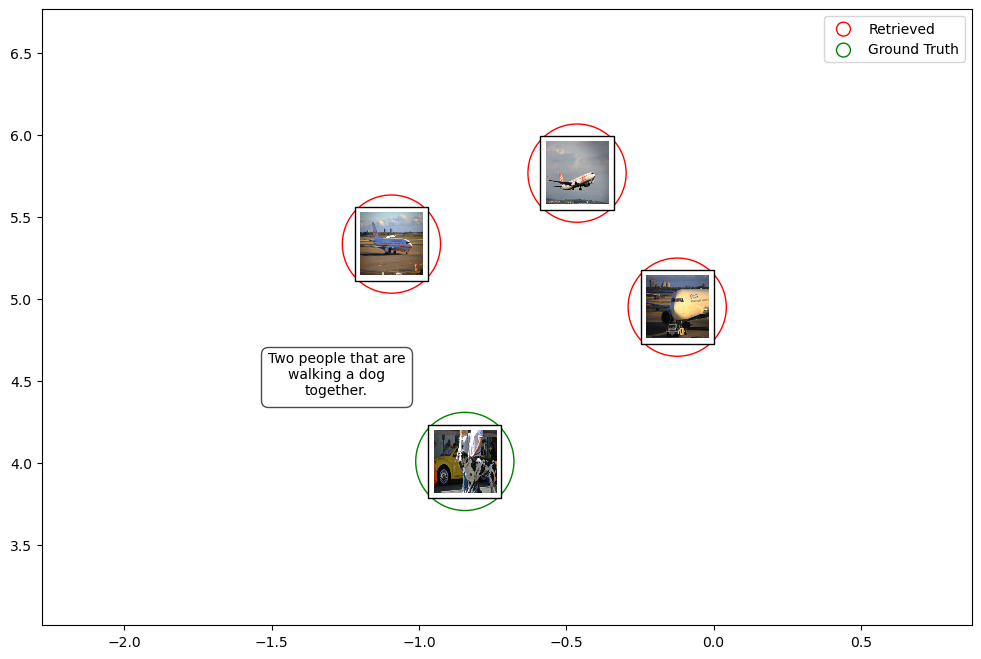

In [115]:
from umap.umap_ import UMAP
from matplotlib.offsetbox import OffsetImage, AnnotationBbox, TextArea
import textwrap

# Combine both sets of embeddings for UMAP
query_embeddings, retrieved_embeddings, gt_embeddings = np.unique(query_embeddings, axis=0), np.unique(retrieved_embeddings, axis=0), np.unique(gt_embeddings, axis=0)
combined_embeddings = np.vstack([query_embeddings, retrieved_embeddings, gt_embeddings]).reshape(-1, 2048)

# Perform UMAP
umap = UMAP(n_neighbors=5, min_dist=0.0, metric='euclidean', random_state=123, n_jobs=1)
umap_result = umap.fit_transform(combined_embeddings)

# Split the transformed embeddings back into queries and images
queries_2d, retrieved_2d, gt_2d = umap_result[:len(query_embeddings)], umap_result[len(query_embeddings):len(query_embeddings)+len(retrieved_embeddings)], umap_result[len(query_embeddings)+len(retrieved_embeddings):]

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))

# Plot retrieved
values = np.unique([xi for x in list(d_db.values()) for xi in x[0]], axis=0)
for i, (x, y) in enumerate(retrieved_2d):
    img = values[i].transpose(1, 2, 0)
    imgbox = OffsetImage(img, zoom=0.2)
    ab = AnnotationBbox(imgbox, (x, y), frameon=True)
    ax.add_artist(ab)
    # plot a red circle around the retrieved with legend
    if i == 0:
        ax.scatter(x, y, s=100, facecolors='none', edgecolors='red', label='Retrieved')
    ax.scatter(x, y, s=5000, facecolors='none', edgecolors='red')

# Plot gt
values = np.unique([xi for x in list(d_gt.values()) for xi in x[0]], axis=0)
for i, (x, y) in enumerate(gt_2d):
    img = values[i].transpose(1, 2, 0)
    imgbox = OffsetImage(img, zoom=0.2)
    ab = AnnotationBbox(imgbox, (x, y), frameon=True)
    ax.add_artist(ab)
    # plot a green circle around the ground truth with legend
    if i == 0:
        ax.scatter(x, y, s=100, facecolors='none', edgecolors='green', label='Ground Truth')
    ax.scatter(x, y, s=5000, facecolors='none', edgecolors='green')

# PLot query
for i, (x, y) in enumerate(queries_2d):
    text = textwrap.fill(query_text, width=20)
    text_box = TextArea(text, textprops=dict(color='black', size=10, ha='center', va='bottom'))
    ab = AnnotationBbox(text_box, (x, y), frameon=True, bboxprops=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='black', alpha=0.7))
    ax.add_artist(ab)
    
ax.set_xlim(umap_result[:, 0].min() - 1, umap_result[:, 0].max() + 1)
ax.set_ylim(umap_result[:, 1].min() - 1, umap_result[:, 1].max() + 1)
plt.legend()
plt.show()